In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io as io 
import numpy as np

import warnings
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.simplefilter(action='ignore', category=FutureWarning)
import zipfile

import os
import glob

# Step 1: Loading and PreProcessing Data
###  ImageDataGenerator().

Defining paths to Training Data (training_path), Cross Validation Data (validation_path), and Testing Data (testing_path)

In [2]:
base_path = './images/Final'
training_path = os.path.join(base_path, 'Train')
validation_path = os.path.join(base_path, 'CrossValidation')
testing_path = os.path.join(base_path, 'Test')

In [3]:
# Finding the Number of Classes

class_folders = glob.glob("./images/Final/Train/*")
print("The number of classes is: " , len(class_folders))
print(class_folders)

The number of classes is:  6
['./images/Final/Train/FalseKillerWhale', './images/Final/Train/DuskyDolphin', './images/Final/Train/HumpbackWhale', './images/Final/Train/Beluga', './images/Final/Train/BlueWhale', './images/Final/Train/BottlenoseDolphin']


In [4]:
# Finding the size of the images by checking in one class
class_folders_LR = glob.glob(class_folders[0]+'/*')
image_sizes = []
for i in range(0, len(class_folders_LR)):
  im = io.imread(class_folders_LR[i])
  image_sizes.append(im.shape)



Using ImageDataGenerator to generate the three different batches (Training, Cross Validation, Teasting) of tensor image data

In [5]:
def preprocess(img):
    width, height = img.shape[0], img.shape[1]
    img = image.array_to_img(img, scale=False)

    # Crop 48x48px
    desired_width, desired_height = 224, 224

    if width < desired_width:
        desired_width = width
    start_x = np.maximum(0, int((width-desired_width)/2))

    img = img.crop((start_x, np.maximum(0, height-desired_height), start_x+desired_width, height))
    img = img.resize((224, 224))

    img = image.img_to_array(img)
    return img / 255.


In [6]:
genTrain = ImageDataGenerator(preprocessing_function=preprocess)
training_data = genTrain.flow_from_directory(directory=training_path, target_size=(224,224), classes=['Beluga', 'BlueWhale', 'BottlenoseDolphin', 'DuskyDolphin', 'FalseKillerWhale', 'HumpbackWhale'], batch_size=10)

genValidation = ImageDataGenerator(preprocessing_function=preprocess)
validation_data = genValidation.flow_from_directory(directory=validation_path, target_size=(224,224), classes=['Beluga', 'BlueWhale', 'BottlenoseDolphin', 'DuskyDolphin', 'FalseKillerWhale', 'HumpbackWhale'], batch_size=10)

genTesting = ImageDataGenerator(preprocessing_function=preprocess)
testing_data = genTesting.flow_from_directory(directory=testing_path, target_size=(224,224), classes=['Beluga', 'BlueWhale', 'BottlenoseDolphin', 'DuskyDolphin', 'FalseKillerWhale', 'HumpbackWhale'], batch_size=10, shuffle=False)

Found 2400 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [7]:
imgs, labels = next(training_data)

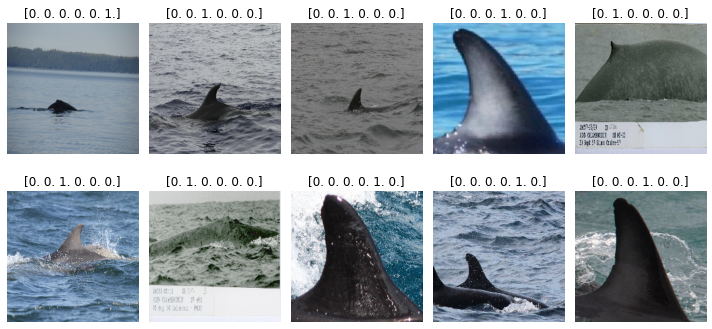

In [8]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10,5))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

plotImages(imgs, labels)

In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(224,224,3),weights='imagenet')
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False
model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc', multi_label = True)])

2022-04-05 11:18:11.867942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.fit(x = training_data, validation_batch_size = validation_data, epochs=10, verbose=2)
output_layer = model.predict(x=testing_data, verbose=0)

Epoch 1/10
240/240 - 2033s - loss: 1.5570 - accuracy: 0.4346 - auc: 0.7578 - 2033s/epoch - 8s/step
Epoch 2/10
240/240 - 1527s - loss: 1.2228 - accuracy: 0.6092 - auc: 0.8726 - 1527s/epoch - 6s/step
Epoch 3/10
240/240 - 1428s - loss: 1.0711 - accuracy: 0.6367 - auc: 0.8956 - 1428s/epoch - 6s/step
Epoch 4/10
240/240 - 2119s - loss: 0.9826 - accuracy: 0.6637 - auc: 0.9096 - 2119s/epoch - 9s/step
Epoch 5/10
240/240 - 1204s - loss: 0.9203 - accuracy: 0.6850 - auc: 0.9181 - 1204s/epoch - 5s/step
Epoch 6/10
240/240 - 4193s - loss: 0.8747 - accuracy: 0.7042 - auc: 0.9246 - 4193s/epoch - 17s/step
Epoch 7/10
240/240 - 1501s - loss: 0.8327 - accuracy: 0.7158 - auc: 0.9320 - 1501s/epoch - 6s/step
Epoch 8/10
240/240 - 1608s - loss: 0.8002 - accuracy: 0.7233 - auc: 0.9370 - 1608s/epoch - 7s/step
Epoch 9/10
240/240 - 1458s - loss: 0.7711 - accuracy: 0.7317 - auc: 0.9407 - 1458s/epoch - 6s/step
Epoch 10/10
240/240 - 1941s - loss: 0.7493 - accuracy: 0.7346 - auc: 0.9440 - 1941s/epoch - 8s/step


In [11]:
Loss, Accuracy, AUC = model.evaluate(x=testing_data, verbose=2)
print("Loss: ", Loss)
print("Prediction Accuracy: ", Accuracy*100, '%')
print("AUC: ", AUC)

30/30 - 182s - loss: 0.7067 - accuracy: 0.7533 - auc: 0.9591 - 182s/epoch - 6s/step
Loss:  0.7067104578018188
Prediction Accuracy:  75.3333330154419 %
AUC:  0.9590533375740051


In [45]:
trueY = testing_data.classes
predictedY = np.argmax(output_layer, axis=-1)

cm = confusion_matrix(trueY, predictedY)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Beluga', 'BlueWhale', 'BottlenoseDolphin', 'DuskyDolphin', 'FalseKillerWhale', 'HumpbackWhale'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.rcParams["figure.figsize"] = (12,12)
plt.show()


[7, 8, 11, 15, 18, 19, 20, 23, 24, 27, 29, 30, 31, 34, 36, 37, 39, 40, 42, 44]


In [46]:
##PLOT WRONG CLASSIFICATIONS

index = []
for i in range(0, len(trueY)):
    if trueY[i] == 2:
        if predictedY[i]==4:
            index.append(i-100)

print(index)
training_bottle = glob.glob("./images/Final/Test/BottlenoseDolphin/*")

listbot = []

for ii in range(0, len(training_bottle)):
    if ii in index:
        listbot.append(training_bottle[ii])
        
f, axes = plt.subplots(round(len(listbot)/5), 5, figsize=(30, 20), sharey=True)
y = 0
for Feat in listbot:
    i, j = divmod(y, 5)
    image = io.imread(Feat)
    axes[i, j].imshow(image)
    # sb.boxplot(x=All[Feat], y = All['Class'], ax=, showfliers = False)
    y= y+1
        

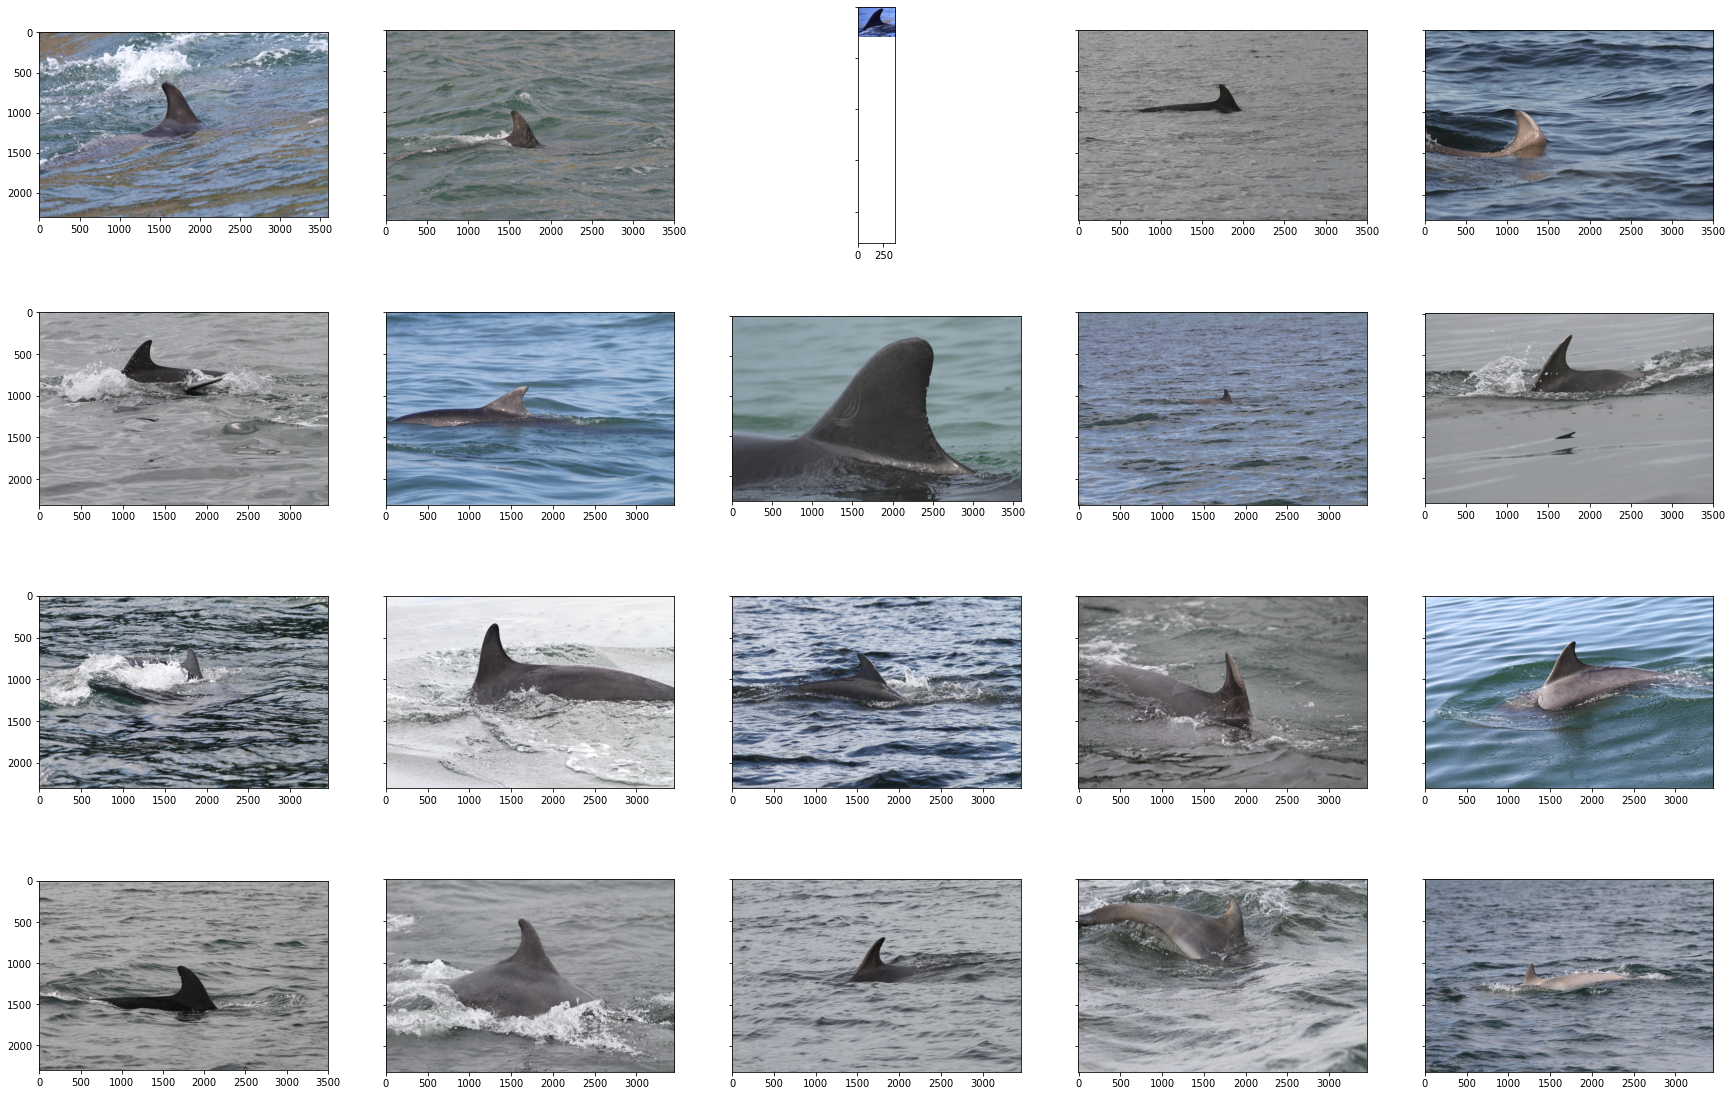

In [13]:
report = classification_report(list(predictedY), trueY, labels=[0, 1, 2, 3, 4, 5])
print(report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        49
           1       0.86      0.93      0.90        46
           2       0.38      0.73      0.50        26
           3       0.98      0.89      0.93        55
           4       0.80      0.56      0.66        71
           5       0.70      0.66      0.68        53

    accuracy                           0.75       300
   macro avg       0.75      0.77      0.75       300
weighted avg       0.79      0.75      0.76       300

